# VAE sur le jeu de données CelebA

A partir de ce notebook de base, l'objectif de ce projet est d'entrainer un VAE sur le jeu de données [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), disponible sur [torchvision](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CelebA.html) ou un sous ensemble de ce jeu de données (il est un peu gros).

Trois objectifs, à réaliser séquentiellement:

- Partie 1 : Entrainer le modèle avec flatten puis MLP (sur 7)
- Partie 2 : Utiliser des CNN à la place de MLP (vous pouvez vous inspirer de l'[implementation suivante](https://medium.com/the-generator/a-basic-variational-autoencoder-in-pytorch-trained-on-the-celeba-dataset-f29c75316b26) (sur 3)
- Partie 3 : Trouver un moyen de conditionner le VAE avec les attributs des images (lunette, moustache etc), l'entrainer et générer votre tête avec des lunettes (sur 6)

La présentation et la qualité des résultats sera noté sur 4.

Rendu : 30 Mai à 12h sur Mootse


In [36]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [37]:
# Download training data from open datasets.
training_data = datasets.CelebA(
    root="C:\\Users\\paulb\\Local\\data",
    split='train',  
    target_type='attr', 
    download=False,    
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CelebA(
    root="C:\\Users\\paulb\\Local\\data",
    split='test',  
    target_type='attr', 
    download=False,    
    transform=ToTensor(),
)

In [38]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 218, 178])
Shape of y: torch.Size([64, 40]) torch.int64


------------------------------------------------------------------------


In [39]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder_mu = nn.Sequential(
            nn.Linear(3*218*178, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.encoder_logvar = nn.Sequential(
            nn.Linear(3*218*178, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, 3*218*178)
        )

    def forward(self, x, train=True):
        x = self.flatten(x)
        z_mu = self.encoder_mu(x)
        z_logvar = self.encoder_logvar(x)
        std = torch.exp(0.5 * z_logvar)
        if train:
            epsilon = torch.randn_like(std)
            z = z_mu + std * epsilon
        else:
            z = z_mu
        x_hat = self.decoder(z)
        return x_hat, z_mu, z_logvar


model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_mu): Sequential(
    (0): Linear(in_features=116412, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (encoder_logvar): Sequential(
    (0): Linear(in_features=116412, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=116412, bias=True)
  )
)


In [40]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred,mu,log_sigma = model(X)
        reconstruction_loss = torch.sum((pred.reshape(X.shape[0],3,218,178) -  X).pow(2)) 
        kl = torch.sum(mu.pow(2) + log_sigma.exp() -1 - log_sigma) 
        loss = reconstruction_loss + kl

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [41]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred,_,_ = model(X,train=False)
            test_loss += loss_fn(pred.reshape(X.shape[0],3,218,178), X).item() 
    test_loss /= num_batches
    correct /= size
    print(f"Test loss: {test_loss:>8f} \n")

In [42]:
import numpy as np

def test_encode(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    preds = []
    all_attrs = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            _,pred,_ = model(X,train=False)
            preds.append(pred.detach().cpu().numpy())
            all_attrs.append(y.numpy())  # Keep as numpy arrays

    # Stack all predictions and attributes
    return np.vstack(preds), np.vstack(all_attrs)

In [43]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2184694.500000  [   64/162770]


KeyboardInterrupt: 

In [ ]:
import time
date = time.ctime().replace(" ", "_").replace(":", "-")
# print(date)
torch.save(model.state_dict(), "vae_celeba_"+date+".pth")
print("Model saved to vae_celeba_"+date+".pth")

Model saved to vae_celeba_Tue_May_20_19-32-05_2025.pth


In [44]:
model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("vae_celeba_"+date+".pth", map_location=device))
model.load_state_dict(torch.load("vae_celeba_Mon_May_19_23-26-08_2025.pth", map_location=device))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_mu): Sequential(
    (0): Linear(in_features=116412, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (encoder_logvar): Sequential(
    (0): Linear(in_features=116412, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=116412, bias=True)
  )
)

Original Image:


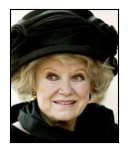

Reconstructed Image from the first:


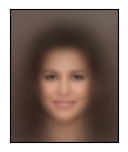

Generated Image 1:


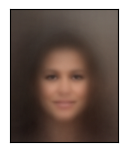

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23405457..0.46839532].


Generated Image 2:


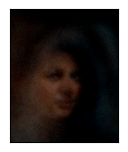

Generated Image 3:


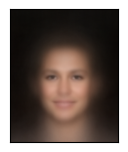

Generated Image 4:


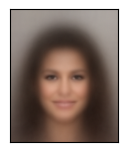

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3283925..0.59188855].


Generated Image 5:


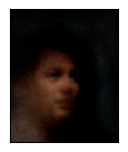

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.31535316..0.5329859].


Generated Image 6:


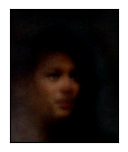

Generated Image 7:


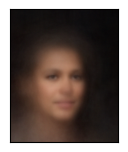

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14384629..0.68105507].


Generated Image 8:


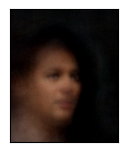

Generated Image 9:


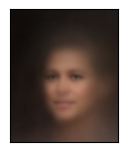

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.034789786..0.6577136].


Generated Image 10:


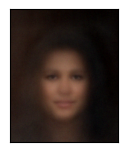

In [74]:
import matplotlib.pyplot as plt

X, y = next(iter(test_dataloader))
X = X.to(device)
pred,_,_ = model(X,train=False)
pred = pred.reshape(X.shape[0],3,218,178)

def plot_images(images, predictions=None):
    plt.figure(figsize=(10, 10))
    if images.ndim == 3:
        images = images.unsqueeze(0)
    for i in range(min(25, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)
    plt.show()

print("Original Image:")
plot_images(X[0].cpu())
print("Reconstructed Image from the first:")
plot_images(pred[0].detach().cpu())

for eps in range(10):
    print(f"Generated Image {eps+1}:")
    plot_images(model.decoder(torch.randn(1,2).to(device)).detach().cpu().reshape(3,218,178))

In [46]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Z, attrs = test_encode(test_dataloader, model)
print(f"Latent space shape: {Z.shape}, Attributes shape: {attrs.shape}")

attr_names = training_data.attr_names

n_rows = 8
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 24))

cmap = ListedColormap(['blue', 'red'])

for i, (ax, attr_name) in enumerate(zip(axes.flatten(), attr_names)):
    if i < len(attr_names):
        scatter = ax.scatter(Z[:,0], Z[:,1], c=attrs[:,i], cmap=cmap, s=1, alpha=0.5)
        ax.set_title(attr_name)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(scatter, ax=ax)

for i in range(len(attr_names), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

------------------------------------------------------------------------


In [75]:
import torch.nn.functional as F #

class CNN_VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 218, 178)
            flattened_size = self.encoder_conv(dummy_input).shape[1]
            print(f"Flattened size: {flattened_size}")

        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)
        
        self.decoder_unflatten_shape = (128, 3, 2) 

        self.decoder_fc_input = nn.Linear(latent_dim, flattened_size)
        
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, self.decoder_unflatten_shape),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(8), 
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Upsample(size=(218, 178), mode='bilinear', align_corners=False),
            nn.Sigmoid() 
        )

        with torch.no_grad():
            dummy_input = torch.randn(1, 2)
            dummy_output = self.decoder_conv(self.decoder_fc_input(dummy_input))
            print(f"Decoder input shape: {dummy_input.shape}, output shape: {dummy_output.shape}")

    def encode(self, x):
        h = self.encoder_conv(x) 
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        h = self.decoder_fc_input(z)
        h = F.relu(h)
        x_hat = self.decoder_conv(h) 
        return x_hat

    def forward(self, x, train=True):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5 * logvar)
        if train:
            epsilon = torch.randn_like(std)
            z = mu + std * epsilon
        else:
            z = mu 
        x_hat = self.decode(z)
        return x_hat, mu, logvar

# Initialize the CNN_VAE model
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
cnn_vae_model = CNN_VAE(latent_dim=2).to(device) 
print(cnn_vae_model)

Flattened size: 768
Decoder input shape: torch.Size([1, 2]), output shape: torch.Size([1, 3, 218, 178])
CNN_VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (14): Conv2d(12

In [76]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_vae_model.parameters(), lr=1e-4)


In [ ]:
epochs = 10


for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train(train_dataloader, cnn_vae_model, loss_fn, optimizer) 
    test(test_dataloader, cnn_vae_model, loss_fn) 
print("Done!")

Epoch 1/10
-------------------------------
loss: 466887.875000  [   64/162770]
loss: 464412.312500  [ 6464/162770]
loss: 430506.812500  [12864/162770]
loss: 414906.906250  [19264/162770]
loss: 417573.625000  [25664/162770]
loss: 383401.750000  [32064/162770]
loss: 381822.468750  [38464/162770]
loss: 402254.937500  [44864/162770]
loss: 349060.093750  [51264/162770]
loss: 372445.812500  [57664/162770]
loss: 381302.500000  [64064/162770]
loss: 378413.562500  [70464/162770]
loss: 364500.093750  [76864/162770]
loss: 370601.250000  [83264/162770]
loss: 364323.906250  [89664/162770]
loss: 372432.093750  [96064/162770]
loss: 354242.906250  [102464/162770]
loss: 376707.375000  [108864/162770]
loss: 354172.937500  [115264/162770]
loss: 339604.968750  [121664/162770]
loss: 356136.812500  [128064/162770]
loss: 342705.500000  [134464/162770]
loss: 348413.218750  [140864/162770]
loss: 349737.625000  [147264/162770]
loss: 350483.812500  [153664/162770]
loss: 351814.531250  [160064/162770]
Test loss: 

In [ ]:
# Save the model

date = time.ctime().replace(" ", "_").replace(":", "-")
torch.save(cnn_vae_model.state_dict(), "cnn_vae_celeba_"+date+".pth")
print("CNN_VAE model saved to cnn_vae_celeba.pth")


CNN_VAE model saved to cnn_vae_celeba.pth


In [ ]:
# Load the model
cnn_vae_model = CNN_VAE(latent_dim=32).to(device)

cnn_vae_model.load_state_dict(torch.load("cnn_vae_celeba_"+date+".pth", map_location=device
))
# cnn_vae_model.load_state_dict(torch.load("cnn_vae_celeba_Mon_May_19_23-03-13_2025.pth", map_location=device))

cnn_vae_model.eval()

RuntimeError: Error(s) in loading state_dict for CNN_VAE:
	Missing key(s) in state_dict: "encoder_conv.0.weight", "encoder_conv.0.bias", "encoder_conv.1.weight", "encoder_conv.1.bias", "encoder_conv.1.running_mean", "encoder_conv.1.running_var", "encoder_conv.3.weight", "encoder_conv.3.bias", "encoder_conv.4.weight", "encoder_conv.4.bias", "encoder_conv.4.running_mean", "encoder_conv.4.running_var", "encoder_conv.6.weight", "encoder_conv.6.bias", "encoder_conv.7.weight", "encoder_conv.7.bias", "encoder_conv.7.running_mean", "encoder_conv.7.running_var", "encoder_conv.10.weight", "encoder_conv.10.bias", "encoder_conv.11.weight", "encoder_conv.11.bias", "encoder_conv.11.running_mean", "encoder_conv.11.running_var", "decoder_fc_input.weight", "decoder_fc_input.bias", "decoder_bn_input.weight", "decoder_bn_input.bias", "decoder_bn_input.running_mean", "decoder_bn_input.running_var", "decoder_conv.1.weight", "decoder_conv.1.bias", "decoder_conv.2.weight", "decoder_conv.2.bias", "decoder_conv.2.running_mean", "decoder_conv.2.running_var", "decoder_conv.4.weight", "decoder_conv.4.bias", "decoder_conv.5.weight", "decoder_conv.5.bias", "decoder_conv.5.running_mean", "decoder_conv.5.running_var", "decoder_conv.7.weight", "decoder_conv.7.bias". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.2.weight", "encoder.2.bias", "encoder.4.weight", "encoder.4.bias", "encoder.7.weight", "encoder.7.bias", "decoder_input.weight", "decoder_input.bias", "decoder.1.weight", "decoder.1.bias", "decoder.3.weight", "decoder.3.bias", "decoder.5.weight", "decoder.5.bias". 
	size mismatch for fc_mu.weight: copying a param with shape torch.Size([2, 4480]) from checkpoint, the shape in current model is torch.Size([32, 4480]).
	size mismatch for fc_mu.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fc_logvar.weight: copying a param with shape torch.Size([2, 4480]) from checkpoint, the shape in current model is torch.Size([32, 4480]).
	size mismatch for fc_logvar.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([32]).

In [ ]:
# Show some images
import matplotlib.pyplot as plt
X, y = next(iter(test_dataloader))
X = X.to(device)
pred,_,_ = cnn_vae_model(X,train=False)


pred = pred.reshape(X.shape[0], 3, 218, 178)


print("First image in the test set:")
plot_images(X[0])
print("Reconstructed image from the first:")
plot_images(pred[0].detach().cpu())
for eps in range(10):
    print(f"Generated image {eps+1}:")
    plot_images(cnn_vae_model.decode(torch.randn(1, 2).to(device)).detach().cpu().reshape(3, 218, 178))


First image in the test set:


NameError: name 'plot_images' is not defined